<div class="alert alert-info">
    <strong>Importation des librairies</strong>
</div>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go

import missingno as msno
from sklearn.impute import KNNImputer,SimpleImputer

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.spatial.distance import cdist

**Fonction pour tracer les courbes**

In [3]:
# Cette fonction permet de tracer le diagramme qu'on veut parmi les 3 suivants : histogramme, diagramme en bâton ou camembert
# La couleur bleue dont le code est ici a été mise par défaut. Pour le diagramme en bâtons, on se limitera par défaut au top 10 des valeurs.

def trace_diagramme (df, columns, type_diagramme, couleur = "rgba(0, 100, 255, 0.7)", top_n = 10) :
    num_cols = len(columns)
    num_rows = num_cols // 2 if num_cols % 2 == 0 else num_cols // 2 + 1

    if type_diagramme == "camembert" :
        fig = sp.make_subplots(rows=num_rows, cols=2, subplot_titles=columns, specs=[[{'type':'pie'}]*2]*num_rows)
    else :
        fig = sp.make_subplots(rows=num_rows, cols=2, subplot_titles=columns)

    titre = ""

    for i, column in enumerate(columns):
        row, col = i // 2 + 1, i % 2 + 1

        if type_diagramme == 'histogramme' :
            titre = "Histogrammes"
            trace = go.Histogram(x=df[column].dropna(), nbinsx=20, marker=dict(color=couleur))
        elif type_diagramme == 'barre' :
            titre = "Diagrammes en bâtons"
            values_count = df[column].value_counts()
            values_count = values_count.head(top_n)
            trace = go.Bar(x=values_count.index, y=values_count.values, marker=dict(color=couleur))
        elif type_diagramme == "camembert" :
            titre = "Camemberts"
            values_count = df[column].value_counts()
            labels = values_count.index
            values = values_count.values
            fig_pie = px.pie(values_count, names=labels, values=values, title=column)
            trace = fig_pie['data'][0]
            # trace = go.Pie(labels=labels, values=values, marker=dict(colors=[couleur]*len(labels)))
            fig.update_layout(margin=dict(t=50, b=0, l=0, r=0))

        fig.add_trace(trace, row=row, col=col)

    fig.update_layout(showlegend=False, height=num_rows * 300, title_text=titre)
    fig.show()

<div class="alert alert-info">
    <strong>Présentation de la problématique et chargement des données</strong>
</div>

In [4]:
df = pd.read_csv("dataset_light.csv", sep=";")
df.head()

,ClientID,age,class of worker,detailed industry code,detailed occupation code,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed code,fill inc questionnaire for veteran's admin,veterans benefits code,weeks worked in year,year,taxable income amount
0,5,10.0,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,0
1,16,13.0,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,0
2,29,4.0,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,95,0
3,39,2.0,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,95,0
4,54,42.0,Private,44,10,Bachelors degree(BA AB BS),0,Not in universe,Married-civilian spouse present,Social services,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,0


<div class="alert alert-info">
    <strong>Analyse descriptive</strong>
</div>

In [5]:
df.shape

(12328, 43)

In [6]:
df['ClientID'].nunique()

12328

In [7]:
df.columns

Index(['ClientID', 'age', 'class of worker', 'detailed industry code',
       'detailed occupation code', 'education', 'wage per hour',
       'enroll in edu inst last wk', 'marital stat', 'major industry code',
       'major occupation code', 'race', 'hispanic origin', 'sex',
       'member of a labor union', 'reason for unemployment',
       'full or part time employment stat', 'capital gains', 'capital losses',
       'dividends from stocks', 'tax filer stat',
       'region of previous residence', 'state of previous residence',
       'detailed household and family stat',
       'detailed household summary in household', 'instance weight',
       'migration code-change in msa', 'migration code-change in reg',
       'migration code-move within reg', 'live in this house 1 year ago',
       'migration prev res in sunbelt', 'num persons worked for employer',
       'family members under 18', 'country of birth father',
       'country of birth mother', 'country of birth self', 'citizen

In [8]:
# Définir l'ID du client comme index
df = df.set_index('ClientID')

In [9]:
df.select_dtypes(include=['object']).columns

Index(['class of worker', 'education', 'enroll in edu inst last wk',
       'marital stat', 'major industry code', 'major occupation code', 'race',
       'hispanic origin', 'sex', 'member of a labor union',
       'reason for unemployment', 'full or part time employment stat',
       'tax filer stat', 'region of previous residence',
       'state of previous residence', 'detailed household and family stat',
       'detailed household summary in household',
       'migration code-change in msa', 'migration code-change in reg',
       'migration code-move within reg', 'live in this house 1 year ago',
       'migration prev res in sunbelt', 'family members under 18',
       'country of birth father', 'country of birth mother',
       'country of birth self', 'citizenship',
       'fill inc questionnaire for veteran's admin'],
      dtype='object')

In [10]:
df.select_dtypes(exclude=['object']).columns

Index(['age', 'detailed industry code', 'detailed occupation code',
       'wage per hour', 'capital gains', 'capital losses',
       'dividends from stocks', 'instance weight',
       'num persons worked for employer', 'own business or self employed code',
       'veterans benefits code', 'weeks worked in year', 'year',
       'taxable income amount'],
      dtype='object')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12328 entries, 5 to 249975
Data columns (total 42 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   age                                         10906 non-null  float64
 1   class of worker                             12328 non-null  object 
 2   detailed industry code                      12328 non-null  int64  
 3   detailed occupation code                    12328 non-null  int64  
 4   education                                   12328 non-null  object 
 5   wage per hour                               12328 non-null  int64  
 6   enroll in edu inst last wk                  12328 non-null  object 
 7   marital stat                                12328 non-null  object 
 8   major industry code                         12328 non-null  object 
 9   major occupation code                       12328 non-null  object 
 10  race     

<div class="alert alert-warning">
    Statistiques de base pour les variables numériques
</div>

In [12]:
df.describe()

,age,detailed industry code,detailed occupation code,wage per hour,capital gains,capital losses,dividends from stocks,instance weight,num persons worked for employer,own business or self employed code,veterans benefits code,weeks worked in year,year,taxable income amount
count,10906.000000,12328.000000,12328.000000,12328.000000,12328.000000,12328.000000,12328.000000,12328.000000,12328.000000,12328.000000,12328.000000,12328.000000,12328.000000,12328.000000
mean,35.205667,15.263709,11.327790,54.780662,434.266061,37.455711,202.095798,1725.533976,1.958306,0.175049,1.517116,23.173589,94.503407,0.061486
std,23.372956,18.018639,14.494317,267.892675,4476.225161,272.666219,2080.002091,997.555326,2.362647,0.552159,0.850197,24.424065,0.500009,0.240229
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,53.140000,0.000000,0.000000,0.000000,0.000000,94.000000,0.000000
25%,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1055.642500,0.000000,0.000000,2.000000,0.000000,94.000000,0.000000
50%,35.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1592.415000,1.000000,0.000000,2.000000,8.000000,95.000000,0.000000
75%,52.000000,33.000000,26.000000,0.000000,0.000000,0.000000,0.000000,2173.210000,4.000000,0.000000,2.000000,52.000000,95.000000,0.000000
max,90.000000,51.000000,46.000000,8000.000000,99999.000000,4356.000000,99999.000000,13114.200000,6.000000,2.000000,2.000000,52.000000,95.000000,1.000000


La variable taxable income amount est une variable binaire. Convertissons le en catégorie.

In [13]:
df['taxable income amount'] = df['taxable income amount'].astype('category')
df['taxable income amount'].value_counts()

0    11570
1      758
Name: taxable income amount, dtype: int64

In [14]:
df['num persons worked for employer'].value_counts()

0    5928
6    2268
1    1403
4     915
3     880
2     613
5     321
Name: num persons worked for employer, dtype: int64

In [15]:
df['own business or self employed code'].value_counts()

0    11159
2      989
1      180
Name: own business or self employed code, dtype: int64

In [16]:
df['veterans benefits code'].value_counts()

2    9291
0    2916
1     121
Name: veterans benefits code, dtype: int64

In [17]:
df['detailed occupation code'].value_counts()

0     6236
2      526
26     477
29     337
19     327
36     256
34     246
10     215
35     211
16     209
12     208
23     199
3      196
33     192
38     187
31     174
37     147
32     145
8      121
17     117
30     116
41     115
24     107
42     104
43     101
44      95
28      89
4       84
18      78
15      75
13      70
39      61
5       57
7       55
14      50
9       47
40      40
21      39
27      38
11      37
25      34
1       33
6       33
22      30
45       9
20       4
46       1
Name: detailed occupation code, dtype: int64

Les variables *own business or self employed code* et *veterans benefits code* représentent des codes. Du coup, elles ne sauraient être considérées comme des variables numériques à proprement parler. Nous allons donc les modifier afin qu'elles deviennent des variables catégorielles.

In [18]:
df['own business or self employed code'] = df['own business or self employed code'].astype('category')
df['veterans benefits code'] = df['veterans benefits code'].astype('category')

A présent, nous allons refaire la description statistique pour les variables numériques

In [19]:
df.describe()

,age,detailed industry code,detailed occupation code,wage per hour,capital gains,capital losses,dividends from stocks,instance weight,num persons worked for employer,weeks worked in year,year
count,10906.000000,12328.000000,12328.000000,12328.000000,12328.000000,12328.000000,12328.000000,12328.000000,12328.000000,12328.000000,12328.000000
mean,35.205667,15.263709,11.327790,54.780662,434.266061,37.455711,202.095798,1725.533976,1.958306,23.173589,94.503407
std,23.372956,18.018639,14.494317,267.892675,4476.225161,272.666219,2080.002091,997.555326,2.362647,24.424065,0.500009
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,53.140000,0.000000,0.000000,94.000000
25%,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1055.642500,0.000000,0.000000,94.000000
50%,35.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1592.415000,1.000000,8.000000,95.000000
75%,52.000000,33.000000,26.000000,0.000000,0.000000,0.000000,0.000000,2173.210000,4.000000,52.000000,95.000000
max,90.000000,51.000000,46.000000,8000.000000,99999.000000,4356.000000,99999.000000,13114.200000,6.000000,52.000000,95.000000


**Tracé des histogrammes pour les valeurs numériques**

In [20]:
columns_num = df.select_dtypes(include=['int64', 'float64']).columns
trace_diagramme(df, columns=columns_num, type_diagramme="histogramme")

<div class="alert alert-warning">
    Caractéristiques catégorielles
</div>

Il y a 31 colonnes catégorielles. Ce que nous allons faire c'est de répartir ces colonnes en 3 groupes (11, 10 et 10) pour faciliter la visualisation de la description.

In [21]:
df.select_dtypes(exclude=['int64', 'float64']).columns

Index(['class of worker', 'education', 'enroll in edu inst last wk',
       'marital stat', 'major industry code', 'major occupation code', 'race',
       'hispanic origin', 'sex', 'member of a labor union',
       'reason for unemployment', 'full or part time employment stat',
       'tax filer stat', 'region of previous residence',
       'state of previous residence', 'detailed household and family stat',
       'detailed household summary in household',
       'migration code-change in msa', 'migration code-change in reg',
       'migration code-move within reg', 'live in this house 1 year ago',
       'migration prev res in sunbelt', 'family members under 18',
       'country of birth father', 'country of birth mother',
       'country of birth self', 'citizenship',
       'own business or self employed code',
       'fill inc questionnaire for veteran's admin', 'veterans benefits code',
       'taxable income amount'],
      dtype='object')

In [22]:
columns1 = ['class of worker', 'education', 'enroll in edu inst last wk',
       'marital stat', 'major industry code', 'major occupation code', 'race',
       'hispanic origin', 'sex', 'member of a labor union',
       'reason for unemployment']

columns2 = ['full or part time employment stat',
       'tax filer stat', 'region of previous residence',
       'state of previous residence', 'detailed household and family stat',
       'detailed household summary in household',
       'migration code-change in msa', 'migration code-change in reg',
       'migration code-move within reg', 'live in this house 1 year ago']

columns3 = ['migration prev res in sunbelt', 'family members under 18',
       'country of birth father', 'country of birth mother',
       'country of birth self', 'citizenship',
       'own business or self employed code',
       "fill inc questionnaire for veteran's admin", 'veterans benefits code',
       'taxable income amount']

In [23]:
df[columns1].describe(include='all')

,class of worker,education,enroll in edu inst last wk,marital stat,major industry code,major occupation code,race,hispanic origin,sex,member of a labor union,reason for unemployment
count,12328,12328,12328,12328,12328,12328,12328,12288,12328,12328,12328
unique,9,17,3,7,24,15,5,9,2,3,6
top,Not in universe,High school graduate,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe
freq,6216,2937,11521,5368,6236,6236,10367,10652,6410,11163,11975


In [24]:
df[columns2].describe(include='all')

,full or part time employment stat,tax filer stat,region of previous residence,state of previous residence,detailed household and family stat,detailed household summary in household,migration code-change in msa,migration code-change in reg,migration code-move within reg,live in this house 1 year ago
count,12328,12328,12328,12328,12328,12328,12328,12328,12328,12328
unique,8,6,6,49,31,8,10,9,10,3
top,Children or Armed Forces,Nonfiler,Not in universe,Not in universe,Householder,Householder,?,?,?,Not in universe under 1 year old
freq,7592,4657,11354,11354,3294,4656,6206,6206,6206,6295


In [25]:
df[columns3].describe(include='all')

,migration prev res in sunbelt,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed code,fill inc questionnaire for veteran's admin,veterans benefits code,taxable income amount
count,12328,12328,12328,12328,12328,12328,12328,12328,12328,12328
unique,4,5,43,43,43,5,3,3,3,2
top,?,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0
freq,6206,8899,9849,9906,10909,10909,11159,12207,9291,11570


Nous avons remarqué qu'il y avait des colonnes avec des points d'interrogation. Avant de tracer les diagrammes, nous allons les transformer en valeurs nulles.

In [26]:
df.replace('?', np.nan, inplace=True)

In [27]:
df[columns1].describe(include='all')

,class of worker,education,enroll in edu inst last wk,marital stat,major industry code,major occupation code,race,hispanic origin,sex,member of a labor union,reason for unemployment
count,12328,12328,12328,12328,12328,12328,12328,12288,12328,12328,12328
unique,9,17,3,7,24,15,5,9,2,3,6
top,Not in universe,High school graduate,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe
freq,6216,2937,11521,5368,6236,6236,10367,10652,6410,11163,11975


In [28]:
df[columns2].describe(include='all')

,full or part time employment stat,tax filer stat,region of previous residence,state of previous residence,detailed household and family stat,detailed household summary in household,migration code-change in msa,migration code-change in reg,migration code-move within reg,live in this house 1 year ago
count,12328,12328,12328,12277,12328,12328,6122,6122,6122,12328
unique,8,6,6,48,31,8,9,8,9,3
top,Children or Armed Forces,Nonfiler,Not in universe,Not in universe,Householder,Householder,Nonmover,Nonmover,Nonmover,Not in universe under 1 year old
freq,7592,4657,11354,11354,3294,4656,5059,5059,5059,6295


In [29]:
df[columns3].describe(include='all')

,migration prev res in sunbelt,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed code,fill inc questionnaire for veteran's admin,veterans benefits code,taxable income amount
count,6122,12328,11890,11898,12101,12328,12328,12328,12328,12328
unique,3,5,42,42,42,5,3,3,3,2
top,Not in universe,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0
freq,5148,8899,9849,9906,10909,10909,11159,12207,9291,11570


**Tracé de courbe pour les variables catégorielles**

In [30]:
# S'il y a plus de 3 catégories, on va tracer un diagrammes à barres, sinon ce sera un camembert
columns_cat = df.select_dtypes(exclude=['int64', 'float64']).columns

cols_for_bars = []
cols_for_pie = []

for col in columns_cat :
    if df[col].nunique() > 3 :
        cols_for_bars.append(col)
    else :
        cols_for_pie.append(col)

print(f"Colonnes pour diagrammes en barres : {cols_for_bars}")
print(f"Colonnes pour camemberts : {cols_for_pie}")

Colonnes pour diagrammes en barres : ['class of worker', 'education', 'marital stat', 'major industry code', 'major occupation code', 'race', 'hispanic origin', 'reason for unemployment', 'full or part time employment stat', 'tax filer stat', 'region of previous residence', 'state of previous residence', 'detailed household and family stat', 'detailed household summary in household', 'migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg', 'family members under 18', 'country of birth father', 'country of birth mother', 'country of birth self', 'citizenship']
Colonnes pour camemberts : ['enroll in edu inst last wk', 'sex', 'member of a labor union', 'live in this house 1 year ago', 'migration prev res in sunbelt', 'own business or self employed code', "fill inc questionnaire for veteran's admin", 'veterans benefits code', 'taxable income amount']


In [31]:
trace_diagramme(df, columns=cols_for_bars, type_diagramme="barre")

In [32]:
trace_diagramme(df, columns=cols_for_pie, type_diagramme="camembert")

In [33]:
df_ind_code_not_in_univ_but_not_children = df.loc[df['major industry code']=='Not in universe or children'].loc[df['education']!='Children']
df_ind_code_not_in_univ_but_not_children['major occupation code'].unique()

array(['Not in universe'], dtype=object)

In [34]:
df_ind_code_not_in_univ_but_not_children['reason for unemployment'].unique()

array(['Not in universe', 'New entrant'], dtype=object)

In [35]:
df_ind_code_not_in_univ_but_not_children['major occupation code'].unique()

array(['Not in universe'], dtype=object)

In [36]:
df['reason for unemployment'].unique()

array(['Not in universe', 'Other job loser', 'Re-entrant', 'Job leaver',
       'New entrant', 'Job loser - on layoff'], dtype=object)

<div class="alert alert-warning">
    Présence de données manquantes
</div>

In [37]:
df.isna().sum()

age                                           1422
class of worker                                  0
detailed industry code                           0
detailed occupation code                         0
education                                        0
wage per hour                                    0
enroll in edu inst last wk                       0
marital stat                                     0
major industry code                              0
major occupation code                            0
race                                             0
hispanic origin                                 40
sex                                              0
member of a labor union                          0
reason for unemployment                          0
full or part time employment stat                0
capital gains                                    0
capital losses                                   0
dividends from stocks                            0
tax filer stat                 

Etant donné qu'il y a trop de colonnes, cherchons juste les colonnes qui ont des valeurs manquantes afin d'afficher le nombre de valeurs manquantes

In [38]:
# Colonnes de valeurs manquantes avec leurs nombres
colonnes_valeurs_manquantes = df.columns[df.isna().any()]
df[colonnes_valeurs_manquantes].isna().sum()

age                               1422
hispanic origin                     40
state of previous residence         51
migration code-change in msa      6206
migration code-change in reg      6206
migration code-move within reg    6206
migration prev res in sunbelt     6206
country of birth father            438
country of birth mother            430
country of birth self              227
dtype: int64

In [39]:
# Pourcentage de valeurs manquantes par colonne
df[colonnes_valeurs_manquantes].isna().sum()*100 / df.shape[0]

age                               11.534718
hispanic origin                    0.324465
state of previous residence        0.413692
migration code-change in msa      50.340688
migration code-change in reg      50.340688
migration code-move within reg    50.340688
migration prev res in sunbelt     50.340688
country of birth father            3.552888
country of birth mother            3.487995
country of birth self              1.841337
dtype: float64

Les variables *migration code-change in msa*, *migration code-move in reg*, *migration code-move within reg* et *migration prev res in sunbelt* ont plus de 30% de valeurs manquantes. Nous ne pouvons donc pas traiter avec elles. Nous allons les supprimer pour qu'elles ne corrompent pas nos analyses.

In [40]:
df.drop(columns=['migration code-change in msa', 'migration code-change in reg',  'migration code-move within reg', 'migration prev res in sunbelt'], axis="columns", inplace=True)

In [41]:
colonnes_valeurs_manquantes = df.columns[df.isna().any()]
df[colonnes_valeurs_manquantes].isna().sum()

age                            1422
hispanic origin                  40
state of previous residence      51
country of birth father         438
country of birth mother         430
country of birth self           227
dtype: int64

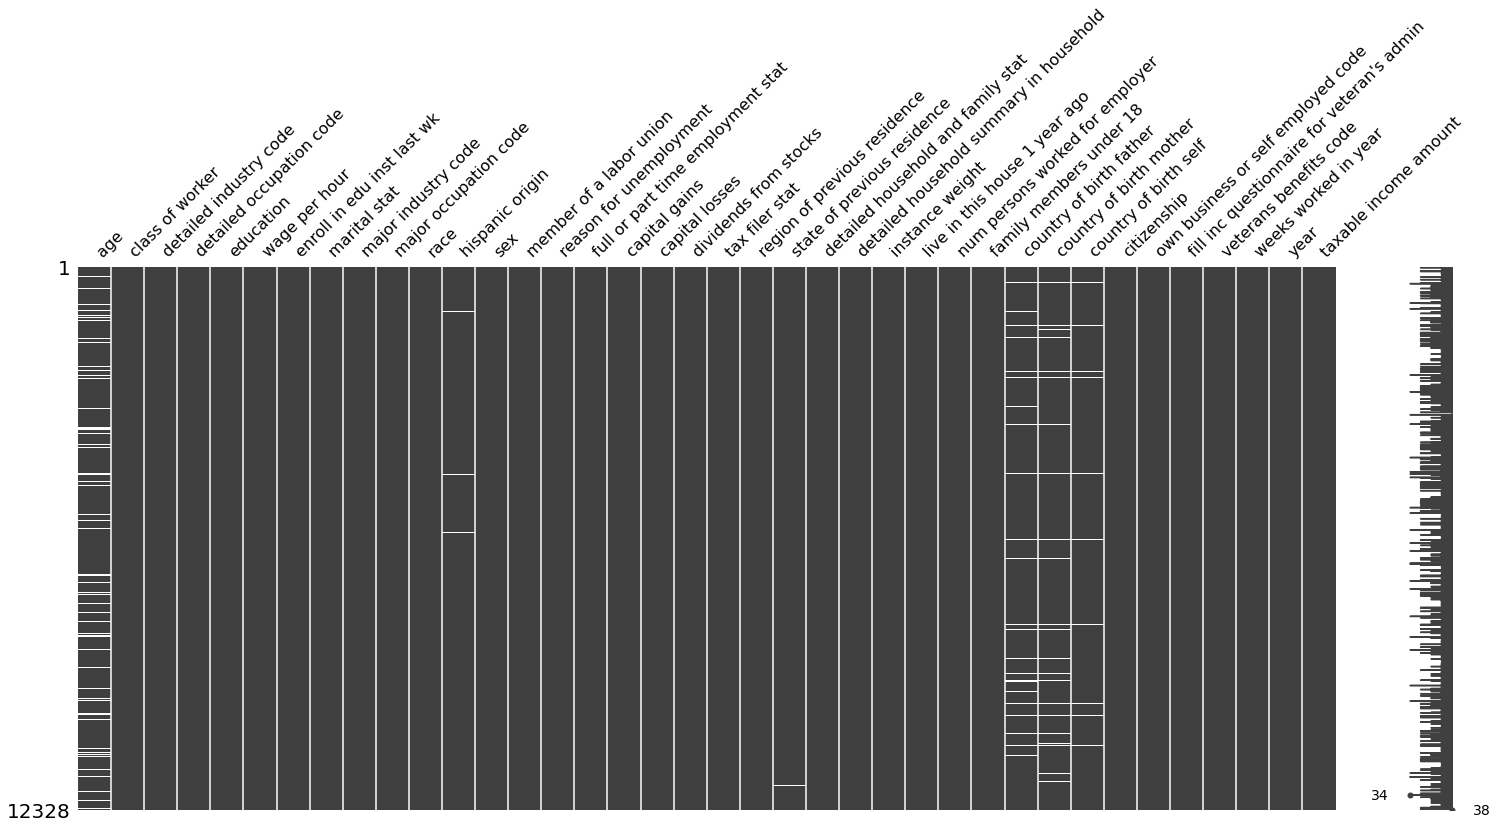

In [42]:
msno.matrix(df)
plt.show()

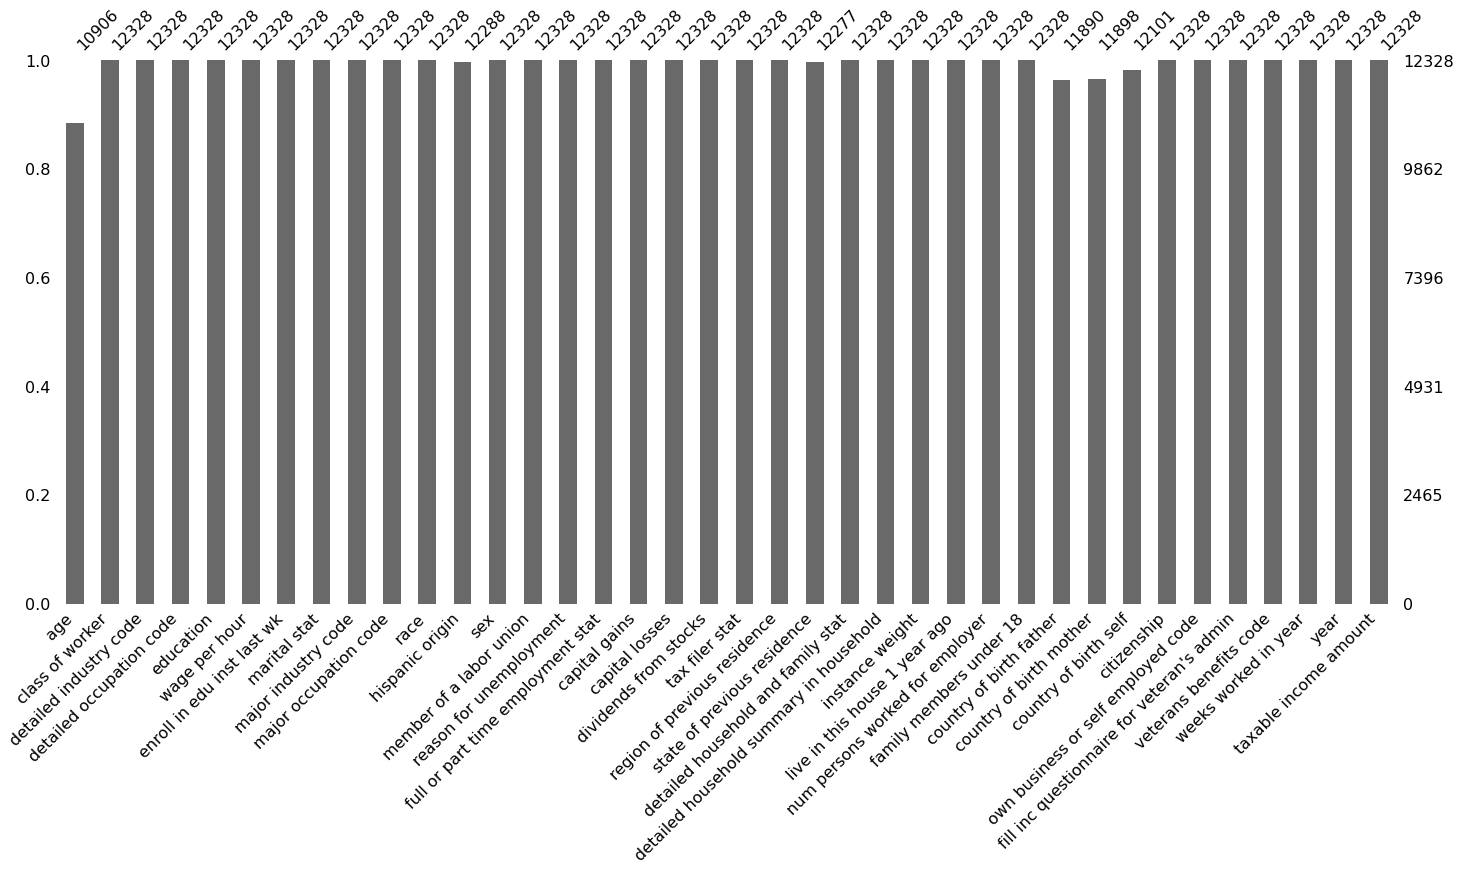

In [43]:
msno.bar(df)
plt.show()

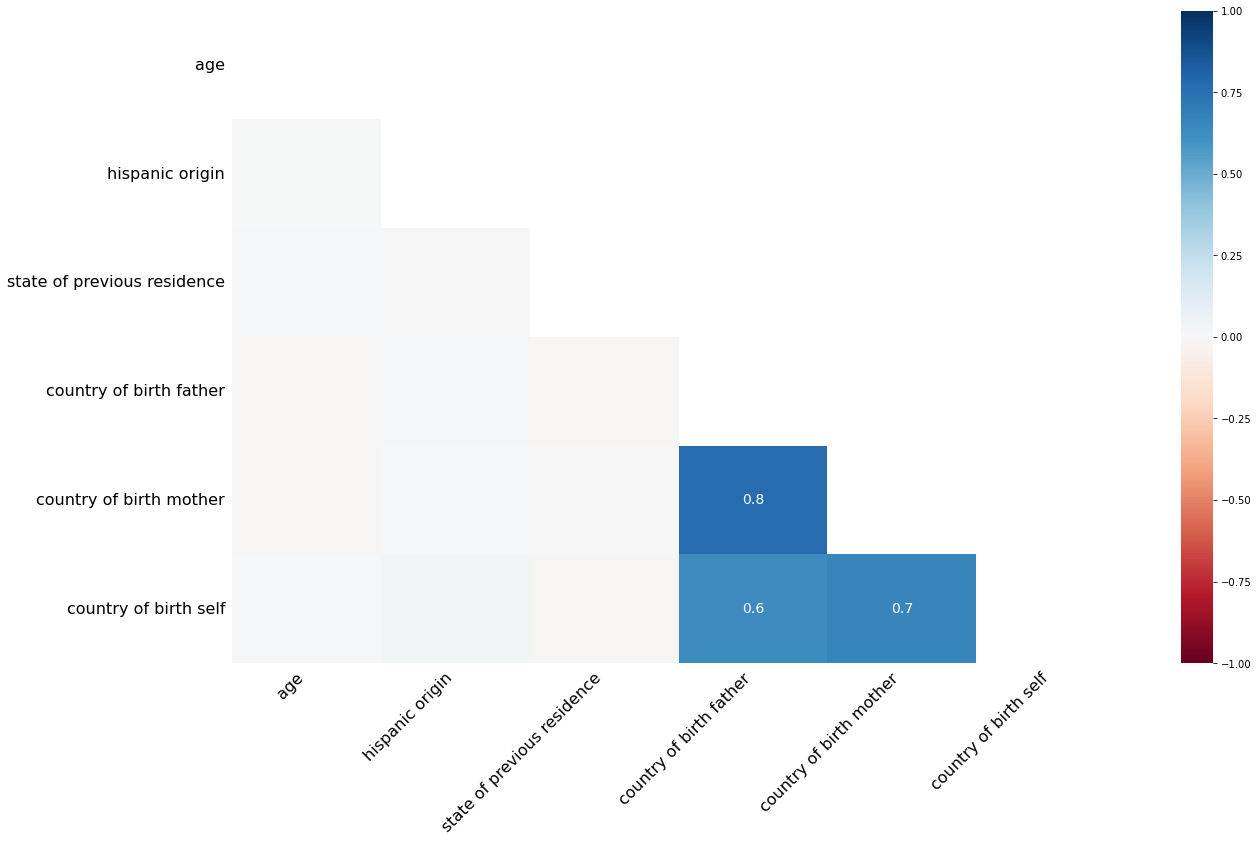

In [44]:
msno.heatmap(df)
plt.show()

On peut déjà observer une corrélation entre les données manquantes. On va tracer un dendogramme pour faire voir visuellement cela.

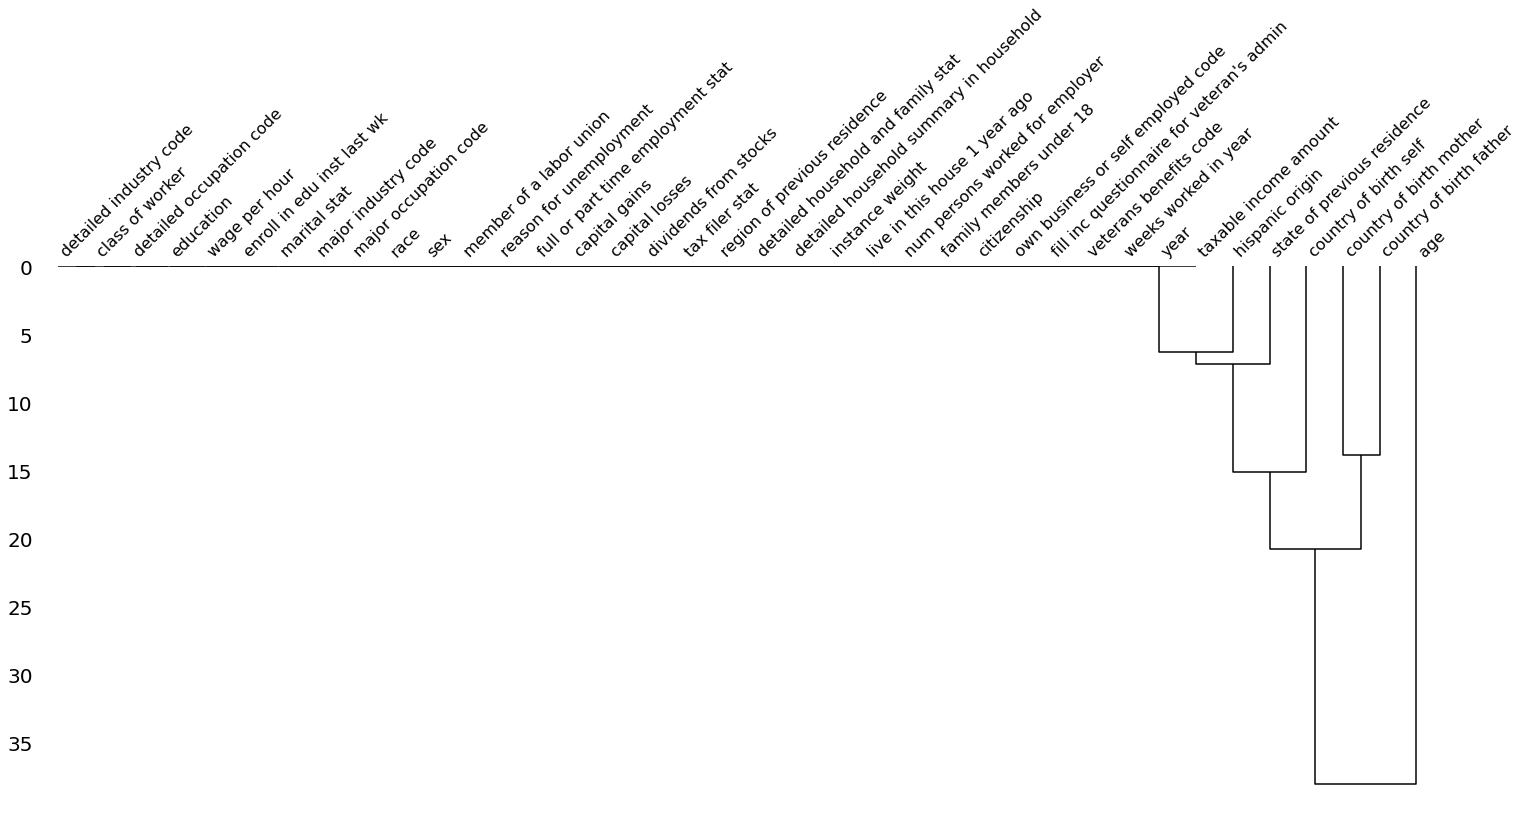

In [45]:
msno.dendrogram(df)
plt.show()

In [46]:
# Imputation par le KNN Imputer pour l'âge
imputer = KNNImputer(n_neighbors=3)

df[['age_imputed']] = imputer.fit_transform(df[['age']])

df.isna().sum()

age                                           1422
class of worker                                  0
detailed industry code                           0
detailed occupation code                         0
education                                        0
wage per hour                                    0
enroll in edu inst last wk                       0
marital stat                                     0
major industry code                              0
major occupation code                            0
race                                             0
hispanic origin                                 40
sex                                              0
member of a labor union                          0
reason for unemployment                          0
full or part time employment stat                0
capital gains                                    0
capital losses                                   0
dividends from stocks                            0
tax filer stat                 

In [47]:
colonnes_valeurs_manquantes.tolist().remove("age")
colonnes_valeurs_manquantes_imputed = [col + "_imputed" for col in colonnes_valeurs_manquantes]

colonnes_valeurs_manquantes_imputed

['age_imputed',
 'hispanic origin_imputed',
 'state of previous residence_imputed',
 'country of birth father_imputed',
 'country of birth mother_imputed',
 'country of birth self_imputed']

In [48]:
# Imputation des variables catégorielles par le mode

imputer_mode = SimpleImputer(strategy='most_frequent')
df[colonnes_valeurs_manquantes_imputed] = imputer_mode.fit_transform(df[colonnes_valeurs_manquantes])

In [49]:
df.isna().sum()

age                                           1422
class of worker                                  0
detailed industry code                           0
detailed occupation code                         0
education                                        0
wage per hour                                    0
enroll in edu inst last wk                       0
marital stat                                     0
major industry code                              0
major occupation code                            0
race                                             0
hispanic origin                                 40
sex                                              0
member of a labor union                          0
reason for unemployment                          0
full or part time employment stat                0
capital gains                                    0
capital losses                                   0
dividends from stocks                            0
tax filer stat                 

In [50]:
colonnes_valeurs_manquantes = df.columns[df.isna().any()]
df.drop(columns=colonnes_valeurs_manquantes, axis="columns", inplace=True)

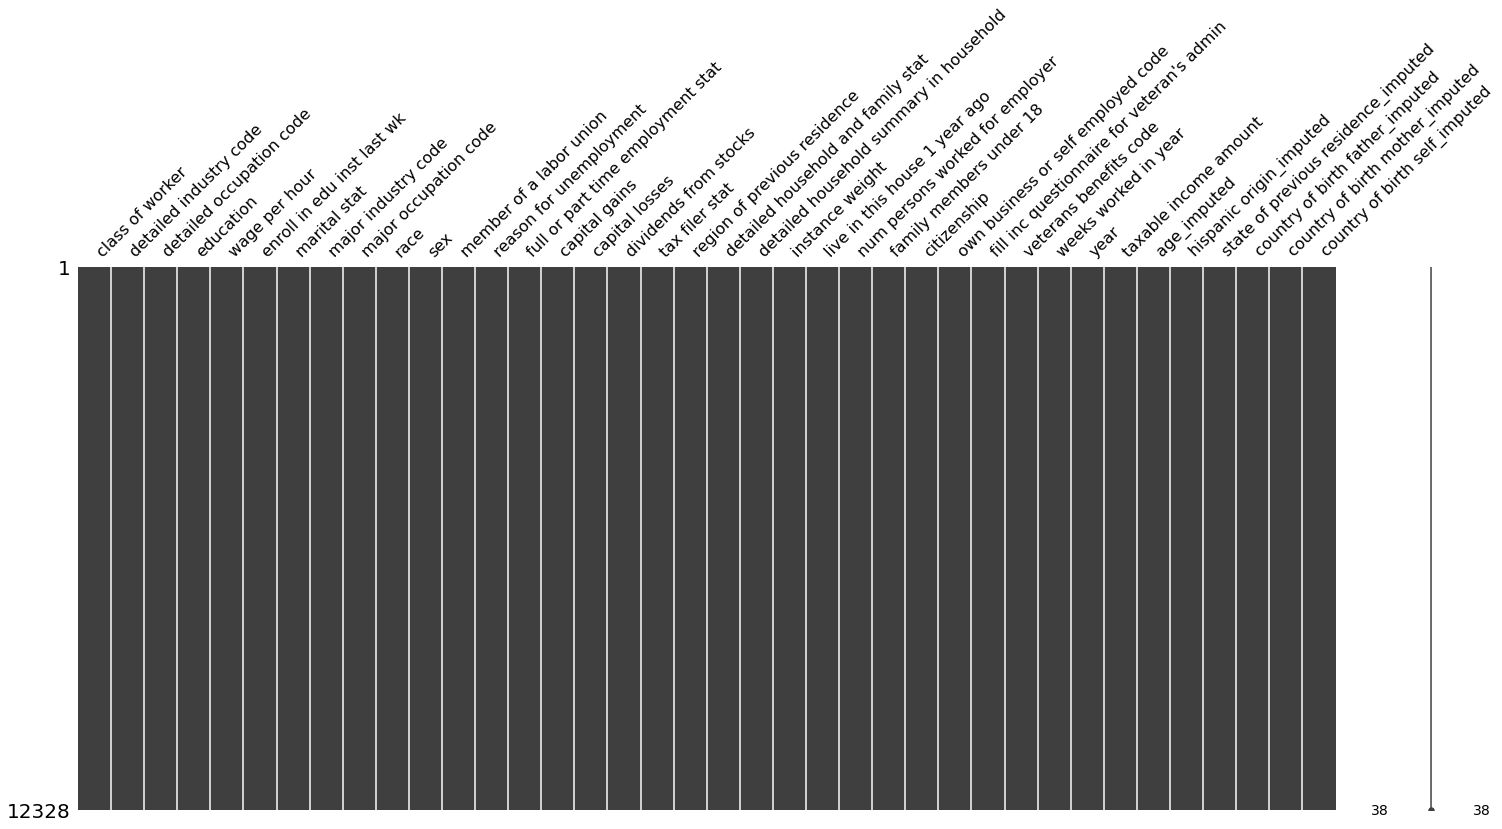

In [51]:
msno.matrix(df)
plt.show()

<div class="alert alert-warning">
    Corrélations intéressantes entre variables numériques
</div>

Sur les variables numériques, on va calculer la corrélation par la méthode de Spearman parce que nos données ne suivent pas une distribution normale et aussi parce que la corrélation de Spearman est moins sensible aux valeurs aberrantes que celle de Pearson.

<AxesSubplot:>

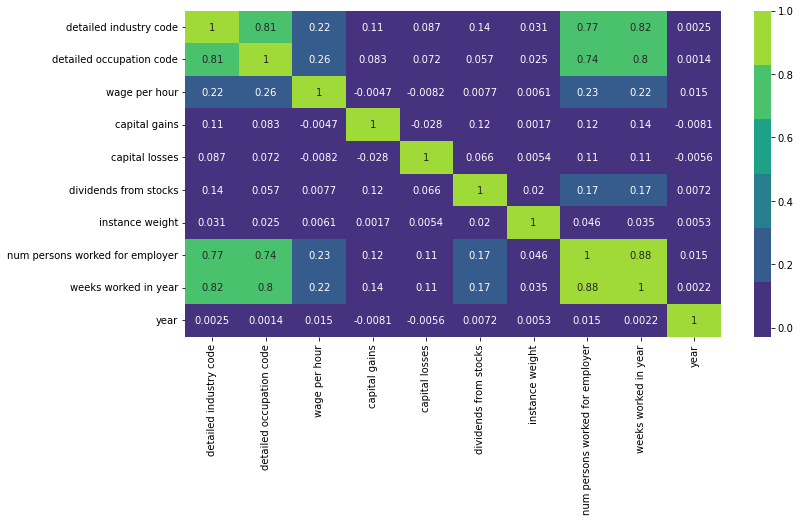

In [52]:
df_numeric = df.select_dtypes(include=[np.number])

correlation_spearman = df_numeric.corr(method='spearman')

plt.figure(figsize=(12, 6))
sns.heatmap(correlation_spearman, fmt='.2g', annot=True, cmap=sns.color_palette("viridis"))

Nous observons des corrélations très fortes entre :
- *detailed industry code* et *detailed occupation code*
- *detailed industry code* et *nums persons worked for employer*
- *detailed industry code* et *weeks worked in year*
- *detailed occupation code* et *nums persons worked for employer*
- *detailed occupation code* et *weeks worked in year*
- *weeks worked in year* et *nums persons worked for employer*

<div class="alert alert-warning">
    Etude approfondie des variables catégorielles
</div>

In [53]:
df_cat = df.select_dtypes(exclude=[np.number])

for col in df_cat.columns :
    print(f"**********{col}**********")
    print(df.groupby(col)[col].count())
    print("----------------------------------------------------\n")

**********class of worker**********
class of worker
Federal government                 156
Local government                   462
Never worked                        20
Not in universe                   6216
Private                           4472
Self-employed-incorporated         216
Self-employed-not incorporated     511
State government                   268
Without pay                          7
Name: class of worker, dtype: int64
----------------------------------------------------

**********education**********
education
10th grade                                 495
11th grade                                 416
12th grade no diploma                      133
1st 2nd 3rd or 4th grade                    92
5th or 6th grade                           192
7th and 8th grade                          497
9th grade                                  375
Associates degree-academic program         259
Associates degree-occup /vocational        333
Bachelors degree(BA AB BS)                12

Cette étude des variables catégorielles nous a permis de faire certaines remarques. Certaines valeurs de variables sont en proportion très faible. Par exemple, pour la variable "class of worker", nous ne tiendrons pas compte de "Without pay" et "Never worked" dans les analyses parce que ces classes représentent respectivement 0.06% et 1.62%.

Par contre, nous ferons des regroupements dans certaines variables comme education, marital stat, full or part time employment stat, age et les country of birth

Pour la variable education, nous allons avoir les classes suivantes : Children, Less than 1st grade, Primary School, Secondary School, Associate degree, Bachelor, Master, Postgraduate

In [54]:
def categorize_education(education):
    if education in ["1st 2nd 3rd or 4th grade", "5th or 6th grade"]:
        return "Primary School"
    if education in ["7th and 8th grade", "9th grade", "10th grade", "11th grade", "12th grade no diploma"]:
        return "Secondary School"
    if education in ["Associates degree-academic program", "Associates degree-occup /vocational"]:
        return "Associates degree"
    if education == "Doctorate degree(PhD EdD)":
        return "Postgraduate"
    if education == "Prof school degree (MD DDS DVM LLB JD)":
        return "Professional degree"
    if education == "Bachelors degree(BA AB BS)":
        return "Bachelor"
    if education == "Masters degree(MA MS MEng MEd MSW MBA)":
        return "Master"    
    return education

df['education_category'] = df['education'].map(categorize_education)

df[['education', 'education_category']].sample(10)

,education,education_category
ClientID,,
11392,Children,Children
95356,Children,Children
192984,Some college but no degree,Some college but no degree
34006,Associates degree-academic program,Associates degree
111627,Children,Children
199133,Bachelors degree(BA AB BS),Bachelor
243557,Bachelors degree(BA AB BS),Bachelor
141492,High school graduate,High school graduate
15731,Children,Children


In [55]:
df.groupby('education_category')['education_category'].count()

education_category
Associates degree              592
Bachelor                      1225
Children                      2917
High school graduate          2937
Less than 1st grade             59
Master                         422
Postgraduate                    74
Primary School                 284
Professional degree            104
Secondary School              1916
Some college but no degree    1798
Name: education_category, dtype: int64

Pour la variable marital_stat, nous allons la catégoriser en Divorced, Married, Never Married, Separated et Widowed

In [56]:
def categorize_marital_status(status):
    if "Married" in status :
        return "Married"
    return status

df['marital_status_category'] = df['marital stat'].map(categorize_marital_status)

df[['marital stat','marital_status_category']].sample(10)

,marital stat,marital_status_category
ClientID,,
40210,Married-civilian spouse present,Married
239624,Widowed,Widowed
185444,Never married,Never married
15431,Married-civilian spouse present,Married
95585,Married-civilian spouse present,Married
103536,Never married,Never married
228259,Never married,Never married
156455,Married-civilian spouse present,Married
220833,Married-civilian spouse present,Married


In [57]:
def categorize_time_employment (status) :
    if status == "Full-time schedules" :
        return "Full-time"
    if status in ["PT for econ reasons usually FT", "PT for econ reasons usually PT", "PT for non-econ reasons usually FT"] :
        return "Part-time"
    if "Unemployed" in status :
        return "Unemployed"
    return status

df['time_employment_category'] = df['full or part time employment stat'].map(categorize_time_employment)

df[['time_employment_category', 'full or part time employment stat']].sample(10)

,time_employment_category,full or part time employment stat
ClientID,,
235014,Children or Armed Forces,Children or Armed Forces
222195,Not in labor force,Not in labor force
220194,Part-time,PT for non-econ reasons usually FT
199214,Full-time,Full-time schedules
196651,Not in labor force,Not in labor force
166121,Full-time,Full-time schedules
28510,Part-time,PT for non-econ reasons usually FT
169916,Children or Armed Forces,Children or Armed Forces
197814,Not in labor force,Not in labor force


In [58]:
def categorize_age(age):
    if age <= 5:
        return "Preschooler"
    if 6 <= age <= 12:
        return "Child"
    if 13 <= age <= 17:
        return "Adolescent"
    if 18 <= age <= 24:
        return "Young Adult"
    if 25 <= age <= 44:
        return "Adult"
    if 45 <= age <= 64:
        return "Middle-aged Adult"    
    return "Elderly"

df['age_category'] = df['age_imputed'].map(categorize_age)

df[['age_imputed', 'age_category']].sample(10)

,age_imputed,age_category
ClientID,,
46450,73.0,Elderly
202022,5.0,Preschooler
245066,8.0,Child
190622,19.0,Young Adult
139482,52.0,Middle-aged Adult
226537,43.0,Adult
24940,5.0,Preschooler
97727,35.0,Adult
172353,38.0,Adult


In [59]:
df['country of birth father'] = df["country of birth father_imputed"].apply(lambda country:'United-States' if country=="United-States" else "Other")
df['country of birth mother'] = df["country of birth mother_imputed"].apply(lambda country:'United-States' if country=="United-States" else "Other")
df['country of birth self'] = df["country of birth self_imputed"].apply(lambda country:'United-States' if country=="United-States" else "Other")

df.groupby('country of birth self')['country of birth self'].count()

country of birth self
Other             1192
United-States    11136
Name: country of birth self, dtype: int64

A présent, nous allons supprimer toutes les colonnes (sauf age) qui nous ont permis de faire les catégories afin de ne pas avoir des informations en double.

In [60]:
df.drop(columns=["education", "marital stat", "full or part time employment stat", 
                 "country of birth father_imputed", "country of birth mother_imputed", "country of birth self_imputed"], axis="columns", inplace=True)

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12328 entries, 5 to 249975
Data columns (total 39 columns):
 #   Column                                      Non-Null Count  Dtype   
---  ------                                      --------------  -----   
 0   class of worker                             12328 non-null  object  
 1   detailed industry code                      12328 non-null  int64   
 2   detailed occupation code                    12328 non-null  int64   
 3   wage per hour                               12328 non-null  int64   
 4   enroll in edu inst last wk                  12328 non-null  object  
 5   major industry code                         12328 non-null  object  
 6   major occupation code                       12328 non-null  object  
 7   race                                        12328 non-null  object  
 8   sex                                         12328 non-null  object  
 9   member of a labor union                     12328 non-null  object  
 1

<div class="alert alert-info">
    <strong>Distribution de l'âge par rapport au montant du revenu imposable</strong>
</div>

In [62]:
df['taxable income amount'].unique()

[0, 1]
Categories (2, int64): [0, 1]

In [69]:
# Calcul de la médiane et de la moyenne par valeur de taxable income amount
grouped_df = df.groupby('taxable income amount')
resultat = grouped_df.agg({'age_imputed' : ['mean', 'median']})

resultat

age_imputed       
                             mean median
taxable income amount                   
0                       30.608470   28.0
1                       43.083113   45.0

In [68]:
# fig = px.violin(df, x='taxable income amount', y='age_imputed', box=True, points="all", hover_data=df.columns)
fig = px.violin(df, x='taxable income amount', y='age_imputed', box=True, color='taxable income amount', points="all")

# Ajouter des titres et libellés d'axes
fig.update_layout(
    title='Distribution de l\'âge par rapport au montant du revenu imposable',
    xaxis_title='Revenu Imposable (0 ou 1)',
    yaxis_title='Âge'
)

# Afficher le graphique
fig.show()

**Interprétation**

Pour la classe 0 : q1 = 8, q2 = 28, q3 = 49
Pour la classe 1 : q1 = 36, q2 = 45, q3 = 53

L'analyse de ce diagramme révèle, d'une part, que 25% des personnes ne déclarant pas gagner plus de 50 000 $ ont moins de 8 ans, et 50% ont moins de 28 ans. En examinant la distribution des points, on constate une certaine homogénéité dans la répartition, avec une densité particulièrement élevée autour de 3 ans.

Pour ceux déclarant un revenu supérieur à 50.000 $, on observe que la moitié a plus de 45 ans, et le quart a plus de 53 ans. Cela suggère que l'âge avancé est associé à des revenus plus élevés. Par ailleurs, la densité est significativement élevée autour de la médiane, ce qui est cohérent. L'examen de la répartition des points indique également la présence de quelques individus gagnant plus de 50.000 autour de 0 an, mais le reste de la population n'apparaît qu'à partir de l'âge de 22 ans.

<div class="alert alert-info">
    <strong>Clustering</strong>
</div>

<div class="alert alert-info">
    <strong>Modèle prédictif</strong>
</div>